In [1]:
import ast
from datetime import datetime
from enum import Enum

import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

from utils.cropping import crop_normalized_bbox  #, crop_normalized_bbox_square
from utils.predict import predict_batch
from utils.enums import MyModel

/media/plk/TOSHIBA EXT/mgr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_model = MyModel.Speciesnet

match use_model:
    case MyModel.DeepFaune:
        from deepfaune.deepfaune_model import get_model
    case MyModel.Speciesnet:
        from speciesnet.speciesnet_model import get_model
    case MyModel.SpeciesnetHead:
        from fine_tuning.speciesnet_head.speciesnet_polish_model import get_model
    case _:
        raise ValueError()

In [3]:
MODEL_NAME = use_model.value
CROP_SIZE = 480 # change and check?
BATCH_SIZE = 50
classifier, class_names = get_model()
classifier.to('cuda')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

images = pd.read_csv('megadetector_results.csv', index_col=0)
images['bbox'] = images["bbox"].apply(
    lambda b: ast.literal_eval(b) if isinstance(b, str) else None)

currently_classifying = images['image_path'][0].rsplit('/')[2]
batch = []
paths = []
results = pd.DataFrame({'image': [], 'detected_animal': [], 'confidence': []})

for _, row in tqdm(images.iterrows(), total=len(images)):
    image_path = row['image_path']

    # only animals
    category = row['category']
    if category != 1:
        results.loc[len(results)] = [image_path, 'empty', 0]
        continue

    # image
    try:
        image = Image.open(image_path).convert("RGB")
        cropped_image = crop_normalized_bbox(image, row['bbox']) # TODO check
    except Exception as e:
        # print(f'Error in image {image_path}: {e}')
        continue

    paths.append(image_path)
    batch.append(cropped_image)

    # run classifier every N images (e.g. 32)
    if len(batch) == BATCH_SIZE:
        preds = predict_batch(classifier, batch, class_names)
        # if confidence (prediction[0][1]) is less than 0.1, classify as other
        detections = [
            prediction[0][0] if prediction[0][1] > 0.1 else 'other' for prediction in preds]
        confs = [prediction[0][1] for prediction in preds]

        batch_results = pd.DataFrame(
            {'image': paths, 'detected_animal': detections, 'confidence': confs})
        results = pd.concat([results, batch_results], ignore_index=True)
        # if confidence less than threshold: other
        batch = []
        paths = []

if len(batch) > 0:
    preds = predict_batch(classifier, batch, class_names)
    detections = [
        prediction[0][0] if prediction[0][1] > 0.1 else 'other' for prediction in preds]
    confs = [prediction[0][1] for prediction in preds]

    batch_results = pd.DataFrame(
        {'image': paths, 'detected_animal': detections, 'confidence': confs})
    results = pd.concat([results, batch_results], ignore_index=True)

now = datetime.now().strftime('%Y_%m_%d_%H_%M')
results.to_csv(f'results/{MODEL_NAME}/results_square_{MODEL_NAME}_{now}.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'deepfaune/models/speciesnet-pytorch-v4.0.1a-v1/always_crop_99710272_22x8_v12_epoch_00148.labels.txt'

### Statistics and plots

In [10]:
path = 'results/speciesnet_head/results_speciesnet_head_2025_11_21_10_03.csv'
results = pd.read_csv(path, index_col=0)
og = pd.read_csv('y_clean_thin.csv')
og = og[['image_path', 'species']]
merged = results.merge(og, left_on='image', right_on='image_path')

In [11]:
merged['model_correct'] = merged.detected_animal == merged.species
merged_no_empty = merged[~((merged.detected_animal == 'empty') & (merged.species != 'empty'))]

In [12]:
N = len(merged_no_empty)
n_model_correct = np.sum(merged_no_empty.model_correct)

print(f'Accuracy {MODEL_NAME}: {100 * n_model_correct / N: .2f}%')

display(merged_no_empty[~merged_no_empty.model_correct].species.value_counts())

accuracy_per_species = (
    merged_no_empty.groupby('species')
      .agg(
          accuracy=('model_correct', 'mean'),  # mean(True/False)
          count=('model_correct', 'size')      # number of samples
      )
      .sort_values('accuracy', ascending=False)
)
display(accuracy_per_species)

Accuracy speciesnet_head:  80.34%


species
red deer       420
bison          388
fox            364
wild boar      358
roe deer       330
beaver         311
empty          266
bird           205
other          190
marten         131
wolf            72
moose           40
squirrel        28
bear            24
wildcat         22
rodent          21
raccoon dog     19
hare            16
mink            13
fallow deer     10
cat              9
dog              7
otter            6
badger           6
polecat          3
stoat            2
lynx             1
Name: count, dtype: int64

,accuracy,count
species,,
badger,0.956835,139
lynx,0.944444,18
empty,0.916927,3202
squirrel,0.891473,258
fallow deer,0.886364,88
roe deer,0.858551,2333
moose,0.849624,266
dog,0.847826,46
bird,0.835474,1246


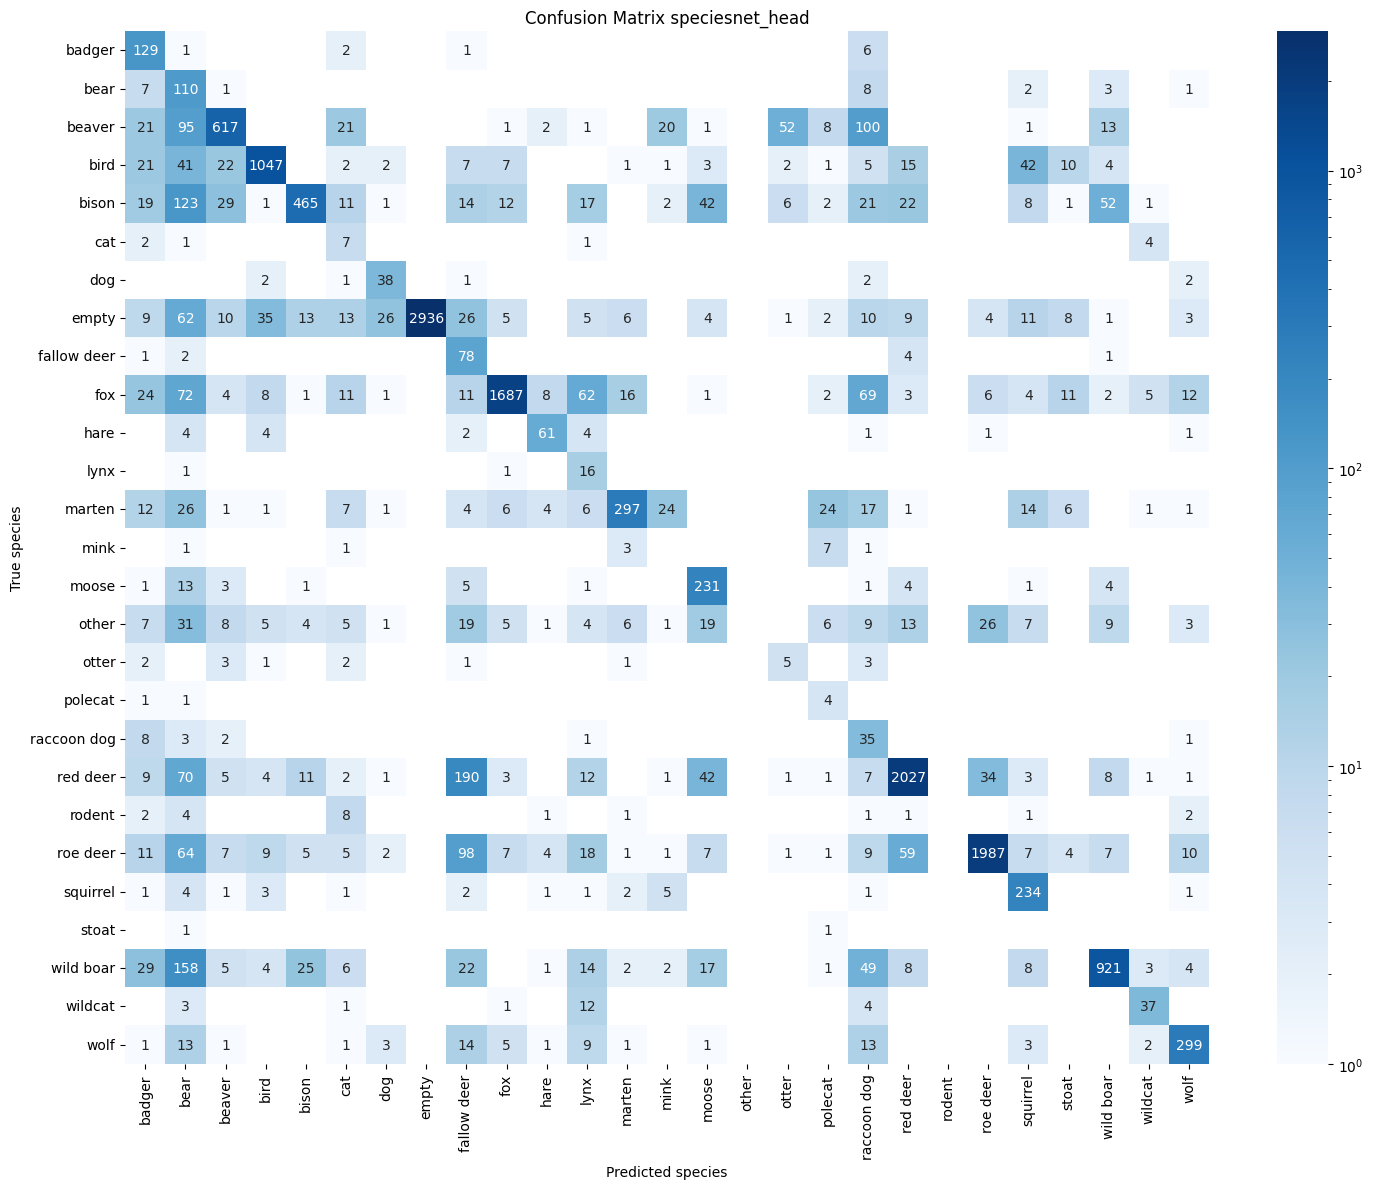

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix

# Create confusion matrix
labels = sorted(merged_no_empty['species'].unique())  # consistent ordering
cm = confusion_matrix(merged_no_empty['species'], merged_no_empty['detected_animal'], labels=labels)

# Plot it
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            norm=LogNorm(vmin=1, vmax=cm.max()))
plt.xlabel("Predicted species")
plt.ylabel("True species")
plt.title(f"Confusion Matrix {MODEL_NAME}")
plt.tight_layout()
now = datetime.now().strftime('%Y_%m_%d_%H_%M')
plt.savefig(f'results/{MODEL_NAME}/cm_{MODEL_NAME}_{now}.jpg')
plt.show()

### Deers thinning

In [26]:
import numpy as np

In [34]:
images = pd.read_csv('y_clean.csv', index_col=0)
images.RelativePath = images.RelativePath.str.replace('\\', '/')

In [36]:
mask_roedeer = images["species"] == "roedeer"
keep_mask = np.random.rand(mask_roedeer.sum()) < 0.3
final_mask = ~mask_roedeer.copy()
final_mask[mask_roedeer] = keep_mask

images_thinned = images[final_mask].reset_index(drop=True)

In [38]:
mask_reddeer = images_thinned["species"] == "reddeer"
keep_mask = np.random.rand(mask_reddeer.sum()) < 0.2
final_mask = ~mask_reddeer.copy()
final_mask[mask_reddeer] = keep_mask

images_thinned = images_thinned[final_mask].reset_index(drop=True)

In [39]:
images[images.species == 'reddeer']

,File,RelativePath,species
6,2023-07-18 02-03-23.JPG,01_CZARNE/B/Lato/2,reddeer
7,2023-07-18 02-03-30.JPG,01_CZARNE/B/Lato/2,reddeer
8,2023-07-18 02-03-38.JPG,01_CZARNE/B/Lato/2,reddeer
9,2023-07-18 02-03-54.JPG,01_CZARNE/B/Lato/2,reddeer
10,2023-07-18 02-06-43.JPG,01_CZARNE/B/Lato/2,reddeer
...,...,...,...
33291,2023-03-06 13-13-42.JPG,30_SUCHEDNIÓW/R/Zima/2,reddeer
33292,2023-03-06 13-13-48.JPG,30_SUCHEDNIÓW/R/Zima/2,reddeer
33293,2023-03-06 13-13-55.JPG,30_SUCHEDNIÓW/R/Zima/2,reddeer
33294,2023-03-06 13-14-11.JPG,30_SUCHEDNIÓW/R/Zima/2,reddeer


In [40]:
images_thinned[images_thinned.species == 'reddeer']

,File,RelativePath,species
6,2023-07-18 02-03-54.JPG,01_CZARNE/B/Lato/2,reddeer
7,2023-07-18 02-06-43.JPG,01_CZARNE/B/Lato/2,reddeer
9,2023-07-26 03-47-00.JPG,01_CZARNE/B/Lato/2,reddeer
10,2023-07-26 03-47-13.JPG,01_CZARNE/B/Lato/2,reddeer
11,2023-07-28 19-09-08.JPG,01_CZARNE/B/Lato/2,reddeer
...,...,...,...
18079,2023-05-31 03-59-22.JPG,30_SUCHEDNIÓW/R/Wiosna/2,reddeer
18090,2022-05-20 08-36-20.JPG,30_SUCHEDNIÓW/R/Wiosna/3,reddeer
18091,2022-05-20 08-37-05.JPG,30_SUCHEDNIÓW/R/Wiosna/3,reddeer
18092,2022-05-20 08-38-02.JPG,30_SUCHEDNIÓW/R/Wiosna/3,reddeer


In [41]:
images[images.species == 'roedeer']

,File,RelativePath,species
83,2022-12-06 21-20-18.JPG,01_CZARNE/B/Późna jesień/3,roedeer
84,2022-12-06 21-20-43.JPG,01_CZARNE/B/Późna jesień/3,roedeer
203,2023-05-13 05-58-53.JPG,01_CZARNE/B/Wiosna/2,roedeer
211,2023-05-05 09-06-50.JPG,01_CZARNE/B/Wiosna/3,roedeer
212,2023-05-05 09-07-14.JPG,01_CZARNE/B/Wiosna/3,roedeer
...,...,...,...
33286,2023-03-03 21-24-55.JPG,30_SUCHEDNIÓW/R/Zima/2,roedeer
33287,2023-03-03 21-25-05.JPG,30_SUCHEDNIÓW/R/Zima/2,roedeer
33288,2023-03-04 12-32-12.JPG,30_SUCHEDNIÓW/R/Zima/2,roedeer
33289,2023-03-04 12-32-20.JPG,30_SUCHEDNIÓW/R/Zima/2,roedeer


In [42]:
images_thinned[images_thinned.species == 'roedeer']

,File,RelativePath,species
37,2022-12-06 21-20-43.JPG,01_CZARNE/B/Późna jesień/3,roedeer
78,2023-05-13 05-58-53.JPG,01_CZARNE/B/Wiosna/2,roedeer
82,2023-05-05 09-11-05.JPG,01_CZARNE/B/Wiosna/3,roedeer
83,2023-05-06 01-13-02.JPG,01_CZARNE/B/Wiosna/3,roedeer
88,2023-05-09 13-42-13.JPG,01_CZARNE/B/Wiosna/3,roedeer
...,...,...,...
18094,2022-06-02 15-07-28.JPG,30_SUCHEDNIÓW/R/Wiosna/3,roedeer
18095,2022-06-08 07-46-13.JPG,30_SUCHEDNIÓW/R/Wiosna/3,roedeer
18098,2023-02-26 17-05-57.JPG,30_SUCHEDNIÓW/R/Zima/2,roedeer
18099,2023-02-26 17-06-05.JPG,30_SUCHEDNIÓW/R/Zima/2,roedeer


In [43]:
images_thinned.to_csv('y_clean_thin.csv')

### Just paths

In [5]:
images = pd.read_csv('y_clean_thin.csv', index_col=0)

In [6]:
images['image_path'] = '../pictures/' + images['RelativePath'] + '/' + images['File']

images = images[['image_path', 'species']]
images.species = images.species.replace(['Empty', 'vehicle', 'human'], 'empty')
images.species = images.species.replace('Undefined', 'other')
images.species = images.species.replace('reddeer', 'red deer')
images.species = images.species.replace('roedeer', 'roe deer')
images.species = images.species.replace('wildboar', 'wild boar')

images.to_csv('y_clean_thin.csv')